# Prosjektoppgave: Norgespris på strøm
# ===============================================================
# 
# DEL 1 – datainnhenting og rensing


In [ ]:
#  Koden i denne delen gjør følgende:
# 1. Leser inn strømprisdata fra CSV (NVE / Kraftpriser)
# 2. Lager en DataFrame med kolonner:
#       dato, time, pris (øre/kWh), område
# 3. Rydder data (manglende verdier, avrunding, duplikater)
# 4. Søker etter uteliggere
# 5. Lagrer renset data til ny CSV-fil

import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
import os
print(os.getcwd())


c:\Users\nmars\OneDrive\Desktop\Data analyse\dataanalyse_1\!Samlingsuka innlevering


In [ ]:
# 1. Leser inn strømprisdata fra CSV (NVE / Kraftpriser)

file_path = Path("Pris (ørekWh) per time for prisområder NO1, NO2, NO3, NO4, NO5 (1).csv")

df_raw = pd.read_csv(file_path, sep=",", quotechar='"', encoding="utf-8")
print("✅ Filen ble funnet og lest inn!")
print(df_raw.head())

✅ Filen ble funnet og lest inn!
         Date, time    Pris Omrade
0  01/09/2023 00:00   9.338    NO1
1  01/09/2023 00:00  91.233    NO2
2  01/09/2023 00:00  23.190    NO3
3  01/09/2023 00:00  23.190    NO4
4  01/09/2023 00:00   9.338    NO5


In [5]:
print("\nKolonner funnet:", list(df_raw.columns))


Kolonner funnet: ['Date, time', 'Pris', 'Omrade']


In [ ]:
# 2: Splitter "Date, time" i dato og time

dt = pd.to_datetime(df_raw["Date, time"], format="%d/%m/%Y %H:%M", errors="coerce")
df_raw["dato"] = dt.dt.date.astype("string")
df_raw["time"] = dt.dt.strftime("%H:00")

In [ ]:
# 3: Lager DataFrame, endrer kolonne navn og datatyper

df_std = pd.DataFrame({
    "dato": df_raw["dato"],
    "time": df_raw["time"],
    "pris (øre/kWh)": pd.to_numeric(df_raw["Pris"], errors="coerce"),
    "område": df_raw["Omrade"].astype("string").str.strip()
})


In [8]:
list(df_raw.columns)


['Date, time', 'Pris', 'Omrade', 'dato', 'time']

In [9]:
df_raw.drop(columns=["Date, time"]).head()



,Pris,Omrade,dato,time
0,9.338,NO1,2023-09-01,00:00
1,91.233,NO2,2023-09-01,00:00
2,23.190,NO3,2023-09-01,00:00
3,23.190,NO4,2023-09-01,00:00
4,9.338,NO5,2023-09-01,00:00


In [ ]:
# 4: Renser data - fjerner rader som mangler dato, time eller pris

before = len(df_std)
df_std = df_std.dropna(subset=["dato", "time", "pris (øre/kWh)"])
after_dropna = len(df_std)
print(f"Fjernet {before - after_dropna} rader med manglende verdier.")



Fjernet 0 rader med manglende verdier.


In [ ]:
# b) Sikrer riktig datatype og avrunder pris til maks 2 desimaler
df_std["pris (øre/kWh)"] = pd.to_numeric(df_std["pris (øre/kWh)"], errors="coerce").round(2)

In [ ]:
# c) Fjerner eventuelle duplikater (samme dato, time, område)
df_std = df_std.drop_duplicates(subset=["dato", "time", "område"]).reset_index(drop=True)

In [ ]:
# 5: Enkle kvalitetskontroller
# -----------------------------
quality_report = {
    "antall_rader": len(df_std),
    "periode_fra": df_std["dato"].min(),
    "periode_til": df_std["dato"].max(),
    "pris_min": float(df_std["pris (øre/kWh)"].min()),
    "pris_max": float(df_std["pris (øre/kWh)"].max()),
    "omrader": sorted(df_std["område"].unique().tolist())
}

print("\n=== KVALITETSRAPPORT ===")
for k, v in quality_report.items():
    print(f"{k}: {v}")


=== KVALITETSRAPPORT ===
antall_rader: 92150
periode_fra: 2023-09-01
periode_til: 2025-10-07
pris_min: -70.93
pris_max: 1046.82
omrader: ['NO1', 'NO2', 'NO3', 'NO4', 'NO5']


In [ ]:
# 6: Finn uteliggere (IQR-metoden)

# Forklaring:
#   IQR = interkvartil-avstand (Q3 - Q1)
#   Uteligger = pris < Q1 - 1.5*IQR eller pris > Q3 + 1.5*IQR

def iqr_bounds(s: pd.Series):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

df_iqr = df_std.copy()
df_iqr["uteligg"] = False  # ny kolonne


In [ ]:
# Beregner grenser for hver prisregion

for omr, sub in df_std.groupby("område"):
    lower, upper = iqr_bounds(sub["pris (øre/kWh)"])
    mask = (df_iqr["område"] == omr) & (
        (df_iqr["pris (øre/kWh)"] < lower) | (df_iqr["pris (øre/kWh)"] > upper)
    )
    df_iqr.loc[mask, "uteligg"] = True

# Lager en oppsummering av uteliggere per område

outlier_summary = (
    df_iqr.groupby("område")["uteligg"]
    .agg(antall_uteliggere="sum", andel_prosent=lambda s: round(100 * s.mean(), 2))
    .reset_index()
    .sort_values("antall_uteliggere", ascending=False)
)

print("\n=== UTELIGGER-OPPSUMMERING ===")
print(outlier_summary)


=== UTELIGGER-OPPSUMMERING ===
  område  antall_uteliggere  andel_prosent
3    NO4                999           5.42
2    NO3                996           5.40
1    NO2                876           4.75
4    NO5                790           4.29
0    NO1                744           4.04


In [ ]:
# 7: Lagrer resultatene
# -----------------------------
df_iqr.to_csv("strompriser_clean_med_flagg.csv", index=False, encoding="utf-8")
df_iqr.loc[~df_iqr["uteligg"], ["dato", "time", "pris (øre/kWh)", "område"]]\
     .to_csv("strompriser_clean_uten_uteliggere.csv", index=False, encoding="utf-8")

print("\n✅ Ferdig!")
print("Filer lagret som:")
print(" - strompriser_clean_med_flagg.csv")
print(" - strompriser_clean_uten_uteliggere.csv")


✅ Ferdig!
Filer lagret som:
 - strompriser_clean_med_flagg.csv
 - strompriser_clean_uten_uteliggere.csv


In [ ]:
# 8 (valgfritt): Viser de første radene

print("\nEksempel på renset data:")
print(df_iqr.head(10))


Eksempel på renset data:
         dato   time  pris (øre/kWh) område  uteligg
0  2023-09-01  00:00            9.34    NO1    False
1  2023-09-01  00:00           91.23    NO2    False
2  2023-09-01  00:00           23.19    NO3    False
3  2023-09-01  00:00           23.19    NO4    False
4  2023-09-01  00:00            9.34    NO5    False
5  2023-09-01  01:00            8.07    NO1    False
6  2023-09-01  01:00           91.28    NO2    False
7  2023-09-01  01:00           22.72    NO3    False
8  2023-09-01  01:00           22.72    NO4    False
9  2023-09-01  01:00            8.07    NO5    False


In [ ]:
# Hvor mye varierer prisene mellom ulike områder?
# Jeg målte timelig spredning som (maks pris − min pris) på tvers av NO1–NO5 for hver time

import pandas as pd

# === 1️ ===Leser renset CSV fil ===

df = pd.read_csv("strompriser_clean_uten_uteliggere.csv",
                 sep=",", quotechar='"', encoding="utf-8")

# === 2️ ===Lager en "timestamp" ved å kombinere dato og time ===
df["datetime"] = pd.to_datetime(df["dato"] + " " + df["time"], format="%Y-%m-%d %H:%M", errors="coerce")

# === 3️ === Lager pivot-tabell slik at hvert område blir en kolonne ===
pivot = df.pivot_table(index="datetime", columns="område", values="pris (øre/kWh)")

# === 4️ === Beregner spredning (maks - min) mellom områder for hver time ===
hourly_spread = pivot.max(axis=1) - pivot.min(axis=1)

# === 5️ === Beregner nøkkeltall ===
snitt_spredning = round(hourly_spread.mean(), 2)
median_spredning = round(hourly_spread.median(), 2)
p95_spredning = round(hourly_spread.quantile(0.95), 2)
maks_spredning = round(hourly_spread.max(), 2)

# === 6️ === Print resultatene ===
print(f"Snitt-spredning: {snitt_spredning} øre/kWh")
print(f"Median-spredning: {median_spredning} øre/kWh")
print(f"95-persentil: {p95_spredning} øre/kWh")
print(f"Maks-spredning (enkeltime): {maks_spredning} øre/kWh")


Snitt-spredning: 44.14 øre/kWh
Median-spredning: 41.0 øre/kWh
95-persentil: 99.68 øre/kWh
Maks-spredning (enkeltime): 136.46 øre/kWh


# Hvordan ser datasettet ut? 


<Figure size 1000x600 with 0 Axes>

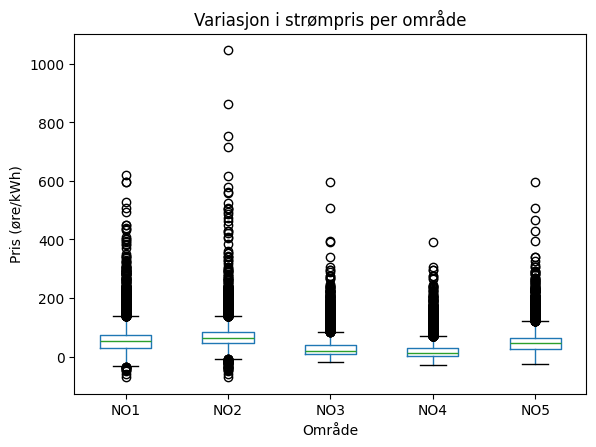


Statistisk oppsummering per område:
          count       mean        std    min      25%     50%      75%  \
område                                                                   
NO1     18430.0  56.470059  42.400451 -70.93  30.2000  53.350  73.5550   
NO2     18430.0  66.921124  40.883661 -70.93  46.4825  61.865  83.0775   
NO3     18430.0  28.531483  31.461178 -17.85   7.5100  18.945  38.7350   
NO4     18430.0  21.147371  26.984815 -27.47   3.4200  11.000  29.9200   
NO5     18430.0  49.904204  36.495562 -25.62  27.0625  46.085  65.0275   

            max  
område           
NO1      620.30  
NO2     1046.82  
NO3      595.14  
NO4      391.31  
NO5      595.14  


In [19]:
import matplotlib.pyplot as plt

# Boxplot for pris (øre/kWh) per område
plt.figure(figsize=(10, 6))
df_iqr.boxplot(column="pris (øre/kWh)", by="område", grid=False)
plt.title("Variasjon i strømpris per område")
plt.suptitle("")  # Fjern automatisk subtitle
plt.xlabel("Område")
plt.ylabel("Pris (øre/kWh)")
plt.show()

# Statistisk oppsummering per område
print("\nStatistisk oppsummering per område:")
print(df_iqr.groupby("område")["pris (øre/kWh)"].describe())

# DEL 2: Visualisering av strømpriser
Lag minst 3–4 forskjellige visualiseringer og forklar hvorfor den formen passer.

Forslag:

Linjediagram: Pris over tid (dag/måned/år).
Boksplott: Fordeling av priser per måned eller område.
Histogram: Hvilke prisnivåer er vanligst?
Heatmap: Pris per time på døgnet vs måned.
Spørsmål:

Når på året er prisene høyest/lavest?
Hvordan varierer prisen gjennom døgnet?
Hvilke forskjeller ser vi mellom områder?


In [ ]:
# Felles oppsett: leser data, lager datetime og hjelpekollonner

import matplotlib.pyplot as plt

# 1) Leser data (tilpass filnavn ved behov)
df = pd.read_csv("strompriser_clean_uten_uteliggere.csv", encoding="utf-8")

# 2) Lager datetime (kombinert dato + time)
df["datetime"] = pd.to_datetime(df["dato"] + " " + df["time"], format="%Y-%m-%d %H:%M", errors="coerce")

# 3) Hjelpevariabler for aggregering
df["år"] = df["datetime"].dt.year
df["måned"] = df["datetime"].dt.month
df["dag"] = df["datetime"].dt.date
df["uke"] = df["datetime"].dt.isocalendar().week.astype(int)
df["time_int"] = pd.to_datetime(df["time"], format="%H:%M").dt.hour

print(df.head())


         dato   time  pris (øre/kWh) område   datetime    år  måned  \
0  2023-09-01  00:00            9.34    NO1 2023-09-01  2023      9   
1  2023-09-01  00:00           91.23    NO2 2023-09-01  2023      9   
2  2023-09-01  00:00           23.19    NO3 2023-09-01  2023      9   
3  2023-09-01  00:00           23.19    NO4 2023-09-01  2023      9   
4  2023-09-01  00:00            9.34    NO5 2023-09-01  2023      9   

          dag  uke  time_int  
0  2023-09-01   35         0  
1  2023-09-01   35         0  
2  2023-09-01   35         0  
3  2023-09-01   35         0  
4  2023-09-01   35         0  


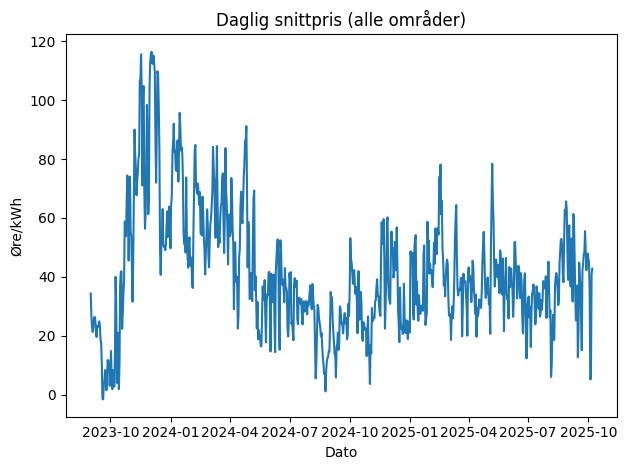

In [21]:
# Linjediagram: Pris over tid (daglig/månedlig snitt)
# Hvorfor linjediagram? Tidsserier vises best som linjer – det gjør trender, sesongmønstre og hopp over tid lett synlige.

# Linjediagram – daglig snittpris (alle områder samlet)
daily = df.groupby("dag", as_index=False)["pris (øre/kWh)"].mean()

plt.figure()
plt.plot(daily["dag"], daily["pris (øre/kWh)"])
plt.title("Daglig snittpris (alle områder)")
plt.xlabel("Dato")
plt.ylabel("Øre/kWh")
plt.tight_layout()
plt.show()

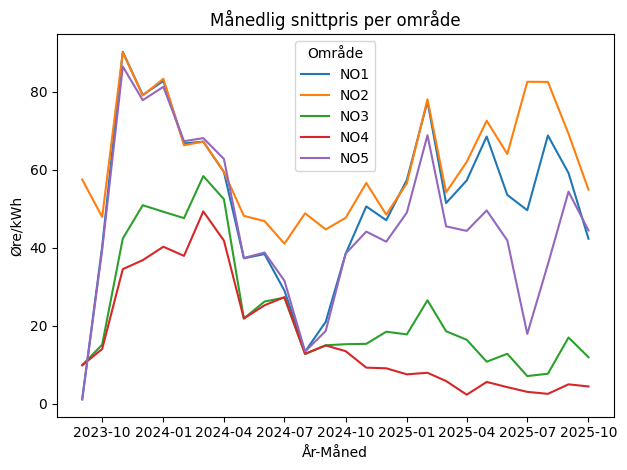

In [22]:
# Alternativ: månedlig snitt per område for ryddigere kurver
monthly_area = (df
                .groupby(["år","måned","område"], as_index=False)["pris (øre/kWh)"]
                .mean()
               )
monthly_area["år_mnd"] = pd.to_datetime(monthly_area["år"].astype(str) + "-" + monthly_area["måned"].astype(str) + "-01")

plt.figure()
for omr, sub in monthly_area.groupby("område"):
    plt.plot(sub["år_mnd"], sub["pris (øre/kWh)"], label=omr)
plt.legend(title="Område")
plt.title("Månedlig snittpris per område")
plt.xlabel("År-Måned")
plt.ylabel("Øre/kWh")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

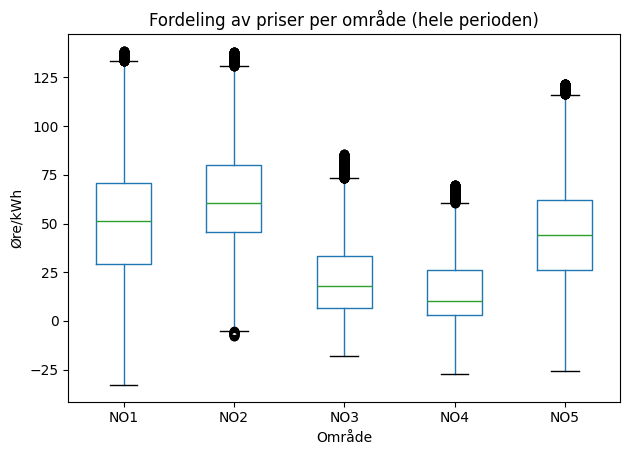

In [ ]:
# Boksplott: Fordeling av priser per måned eller per område

# Boksplott per område (hele perioden)

plt.figure()
df.boxplot(by="område", column=["pris (øre/kWh)"], grid=False)
plt.suptitle("")
plt.title("Fordeling av priser per område (hele perioden)")
plt.xlabel("Område")
plt.ylabel("Øre/kWh")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

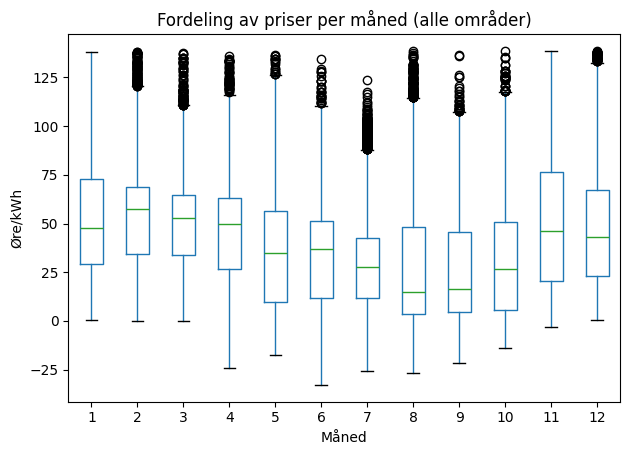

In [ ]:
# Boksplott per måned (alle områder samlet)

monthly_dist = df[["måned","pris (øre/kWh)"]].copy()

plt.figure()
monthly_dist.boxplot(by="måned", column=["pris (øre/kWh)"], grid=False)
plt.suptitle("")  # fjern automatisk suptitle
plt.title("Fordeling av priser per måned (alle områder)")
plt.xlabel("Måned")
plt.ylabel("Øre/kWh")
plt.tight_layout()
plt.show()

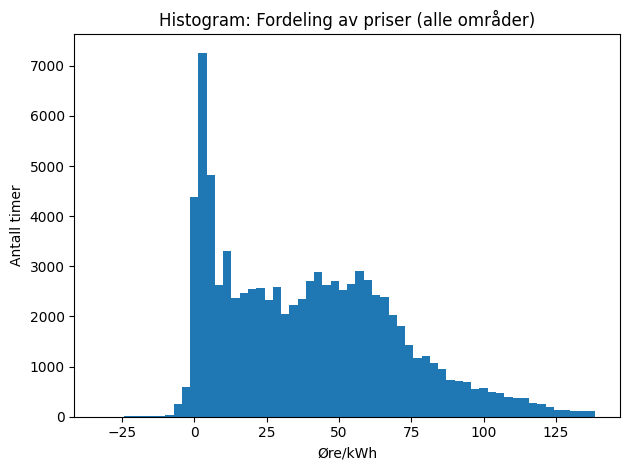

In [25]:
# Histogrammet viser fordelingen av priser – hvilke nivåer forekommer oftest, og om det finnes tunge haler.

# Histogram over prisfordeling (alle områder)
plt.figure()
plt.hist(df["pris (øre/kWh)"].dropna(), bins=60)
plt.title("Histogram: Fordeling av priser (alle områder)")
plt.xlabel("Øre/kWh")
plt.ylabel("Antall timer")
plt.tight_layout()
plt.show()

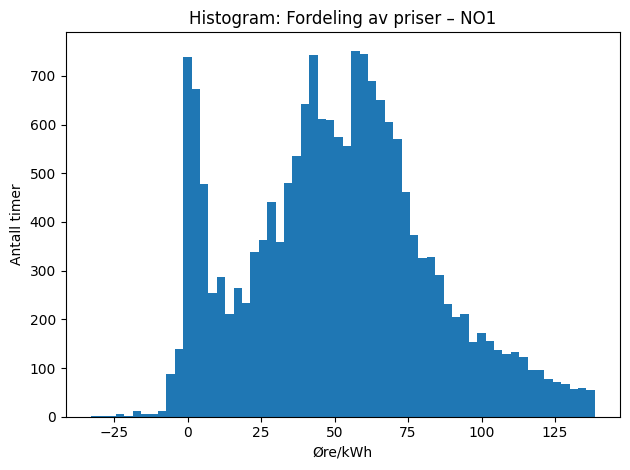

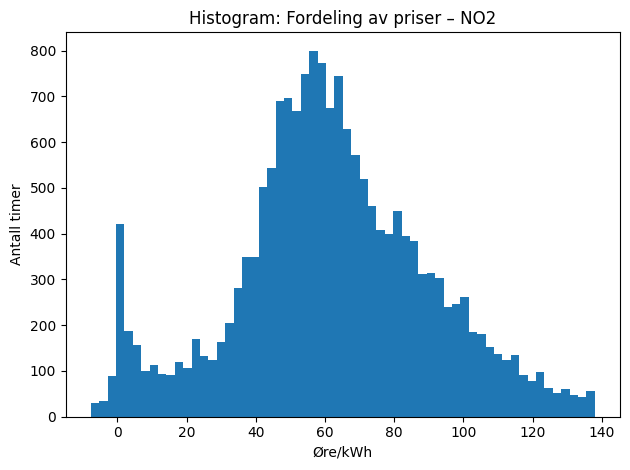

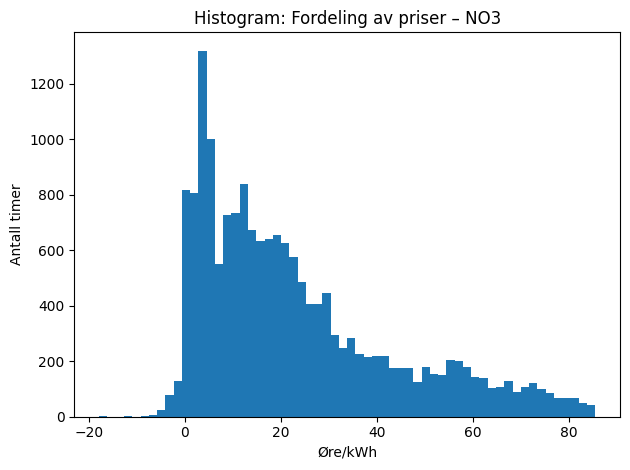

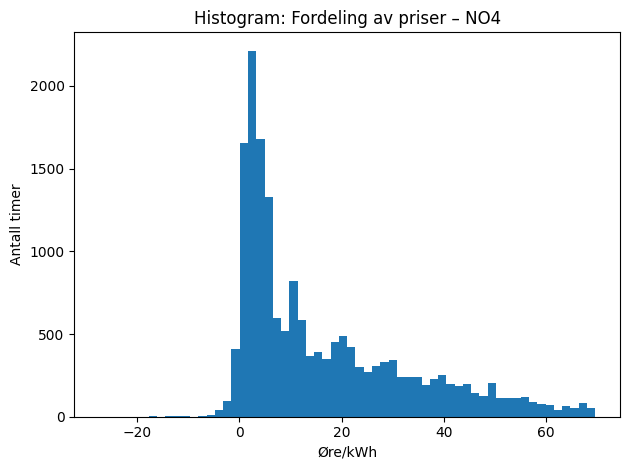

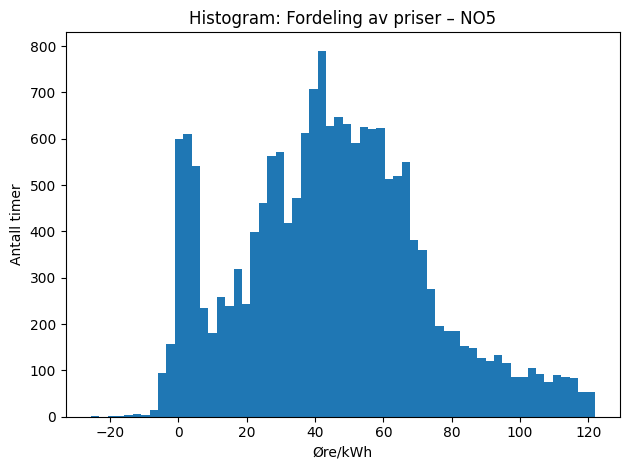

In [ ]:
# (Valgfritt) Histogram per område – kjører separate figurer
for omr, sub in df.groupby("område"):
    plt.figure()
    plt.hist(sub["pris (øre/kWh)"].dropna(), bins=60)
    plt.title(f"Histogram: Fordeling av priser – {omr}")
    plt.xlabel("Øre/kWh")
    plt.ylabel("Antall timer")
    plt.tight_layout()
    plt.show()

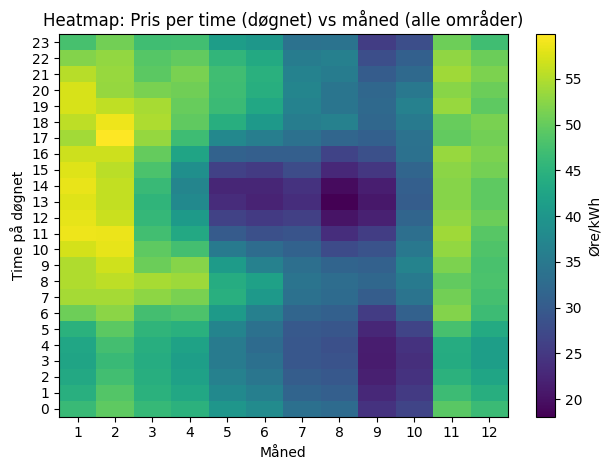

In [27]:
# Heatmap: Pris per time på døgnet vs måned

# Gjennomsnittspris per time på døgnet (0-23) og måned (1-12), alle områder
pivot_ht = df.pivot_table(index="time_int", columns="måned", values="pris (øre/kWh)", aggfunc="mean")

plt.figure()
plt.imshow(pivot_ht.values, aspect="auto", origin="lower")
plt.colorbar(label="Øre/kWh")
plt.title("Heatmap: Pris per time (døgnet) vs måned (alle områder)")
plt.xlabel("Måned")
plt.ylabel("Time på døgnet")
plt.xticks(ticks=np.arange(pivot_ht.shape[1]), labels=pivot_ht.columns)
plt.yticks(ticks=np.arange(pivot_ht.shape[0]), labels=pivot_ht.index)
plt.tight_layout()
plt.show()

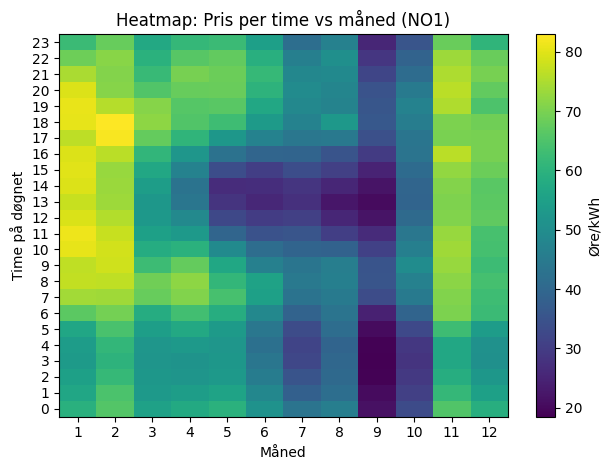

In [ ]:
# (Valgfritt) Heatmap for ett område om gangen (endre 'area_to_plot')

area_to_plot = "NO1"
pivot_ht_area = (df[df["område"]==area_to_plot]
                 .pivot_table(index="time_int", columns="måned", values="pris (øre/kWh)", aggfunc="mean"))

plt.figure()
plt.imshow(pivot_ht_area.values, aspect="auto", origin="lower")
plt.colorbar(label="Øre/kWh")
plt.title(f"Heatmap: Pris per time vs måned ({area_to_plot})")
plt.xlabel("Måned")
plt.ylabel("Time på døgnet")
plt.xticks(ticks=np.arange(pivot_ht_area.shape[1]), labels=pivot_ht_area.columns)
plt.yticks(ticks=np.arange(pivot_ht_area.shape[0]), labels=pivot_ht_area.index)
plt.tight_layout()
plt.show()

In [ ]:
#A) Når på året er prisene høyest/lavest?

# Strategi: Finner månedlige gjennomsnitt og henter måneden med høyest/lavest snitt.

# Snitt per måned (alle områder samlet)
monthly_avg = df.groupby("måned", as_index=False)["pris (øre/kWh)"].mean()

# Finner høyeste/laveste måned
row_max = monthly_avg.loc[monthly_avg["pris (øre/kWh)"].idxmax()]
row_min = monthly_avg.loc[monthly_avg["pris (øre/kWh)"].idxmin()]

print("Høyest gjennomsnittlig pris:")
print(f"  Måned: {int(row_max['måned'])}, Snitt: {row_max['pris (øre/kWh)']:.2f} øre/kWh")

print("Lavest gjennomsnittlig pris:")
print(f"  Måned: {int(row_min['måned'])}, Snitt: {row_min['pris (øre/kWh)']:.2f} øre/kWh")

# (Valgfritt) per område:
monthly_area_avg = df.groupby(["område","måned"], as_index=False)["pris (øre/kWh)"].mean()
print("\nTopp 5 høyeste månedssnitt per område:")
print(monthly_area_avg.sort_values("pris (øre/kWh)", ascending=False).head())


Høyest gjennomsnittlig pris:
  Måned: 2, Snitt: 53.57 øre/kWh
Lavest gjennomsnittlig pris:
  Måned: 9, Snitt: 26.52 øre/kWh

Topp 5 høyeste månedssnitt per område:
   område  måned  pris (øre/kWh)
22    NO2     11       72.332000
1     NO1      2       71.460916
13    NO2      2       71.319851
12    NO2      1       70.784854
0     NO1      1       70.454910


In [ ]:
# B) Hvordan varierer prisen gjennom døgnet?"
# Strategi: Beregner snitt per time (0–23).

# Snitt per time (alle områder)
hour_avg = df.groupby("time_int", as_index=False)["pris (øre/kWh)"].mean()
print("Snittpris per time (0–23):")
print(hour_avg)

# Høyeste/laveste time på døgnet
max_hour_row = hour_avg.loc[hour_avg["pris (øre/kWh)"].idxmax()]
min_hour_row = hour_avg.loc[hour_avg["pris (øre/kWh)"].idxmin()]
print(f"\nHøyeste time-snitt: kl {int(max_hour_row['time_int']):02d}:00 → {max_hour_row['pris (øre/kWh)']:.2f} øre/kWh")
print(f"Laveste time-snitt: kl {int(min_hour_row['time_int']):02d}:00 → {min_hour_row['pris (øre/kWh)']:.2f} øre/kWh")

# (Valgfritt) per område:
hour_area_avg = df.groupby(["område","time_int"], as_index=False)["pris (øre/kWh)"].mean()
print("\nSnittpris per time per område (eksempel, første 20 rader):")
print(hour_area_avg.head(20))




Snittpris per time (0–23):
    time_int  pris (øre/kWh)
0          0       38.908234
1          1       37.144728
2          2       35.902242
3          3       35.148034
4          4       35.292183
5          5       36.995225
6          6       40.119946
7          7       42.682075
8          8       43.438611
9          9       42.317169
10        10       40.593691
11        11       38.660160
12        12       36.554489
13        13       35.012255
14        14       35.236296
15        15       37.076218
16        16       39.439079
17        17       41.741242
18        18       43.986793
19        19       44.635781
20        20       44.369617
21        21       44.060087
22        22       42.898440
23        23       40.221940

Høyeste time-snitt: kl 19:00 → 44.64 øre/kWh
Laveste time-snitt: kl 13:00 → 35.01 øre/kWh

Snittpris per time per område (eksempel, første 20 rader):
   område  time_int  pris (øre/kWh)
0     NO1         0       49.971604
1     NO1         1      

In [31]:
# C) Hvilke forskjeller ser vi mellom områder?
# Strategi: Sammenlikn snitt, median, spredning per område. Ta også “timelig spredning” = (maks−min) på tvers av områder per time.

# Statistikk per område
area_stats = (df.groupby("område")["pris (øre/kWh)"]
                .agg(["count","mean","median","std","min","max"])
                .rename(columns={
                    "count":"antall",
                    "mean":"snitt",
                    "median":"median",
                    "std":"std_avvik",
                    "min":"min",
                    "max":"max"
                }))
print("Pris-statistikk per område:")
print(area_stats)

# Timelig spredning mellom områder (maks-min per time)
pivot = df.pivot_table(index="datetime", columns="område", values="pris (øre/kWh)")
hourly_spread = pivot.max(axis=1) - pivot.min(axis=1)

print(f"\nSnitt-spredning (maks-min) mellom områder per time: {hourly_spread.mean():.2f} øre/kWh")
print(f"Median-spredning: {hourly_spread.median():.2f} øre/kWh")
print(f"95-persentil: {hourly_spread.quantile(0.95):.2f} øre/kWh")
print(f"Maks-spredning (enkeltime): {hourly_spread.max():.2f} øre/kWh")

# (Valgfritt) rangér områder etter snittpris
print("\nOmråder rangert etter snittpris (høyest → lavest):")
print(area_stats.sort_values("snitt", ascending=False)[["snitt"]])


Pris-statistikk per område:
        antall      snitt  median  std_avvik    min     max
område                                                     
NO1      17686  51.269976  51.530  31.718120 -32.94  138.54
NO2      17554  61.736012  60.430  28.374709  -7.68  137.97
NO3      17434  23.247103  17.665  20.554846 -17.85   85.52
NO4      17431  16.444022   9.980  16.856835 -27.47   69.66
NO5      17640  45.054415  44.300  27.497892 -25.62  121.89

Snitt-spredning (maks-min) mellom områder per time: 44.14 øre/kWh
Median-spredning: 41.00 øre/kWh
95-persentil: 99.68 øre/kWh
Maks-spredning (enkeltime): 136.46 øre/kWh

Områder rangert etter snittpris (høyest → lavest):
            snitt
område           
NO2     61.736012
NO1     51.269976
NO5     45.054415
NO3     23.247103
NO4     16.444022


# DEL 3
Brukerfunksjoner med postnummer
Lag funksjoner som tar inn postnummer → finner hvilket NO-område det tilhører → returnerer:

Dagens strømpriser (time for time).
Snittpris siste 3 år.
Gjennomsnittspris per time (når på døgnet er strømmen dyrest/billigst?).
Lag en rapport med grafer for dette området.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Leser renset data

df = pd.read_csv("strompriser_clean_uten_uteliggere.csv", encoding="utf-8")

# Lager datetime og hjelpesøyler
df["datetime"] = pd.to_datetime(df["dato"] + " " + df["time"], format="%Y-%m-%d %H:%M", errors="coerce")
df["year"]  = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"]   = df["datetime"].dt.date
# time er "HH:MM" – trekk ut heltalls-time (0–23)
df["hour"]  = pd.to_datetime(df["time"], format="%H:%M").dt.hour

# Siste dato i datasettet (brukes som "i dag" hvis datasettet ikke er helt ferskt)
LATEST_DATE = df["day"].max()

In [33]:
df.head

<bound method NDFrame.head of              dato   time  pris (øre/kWh) område            datetime  year  \
0      2023-09-01  00:00            9.34    NO1 2023-09-01 00:00:00  2023   
1      2023-09-01  00:00           91.23    NO2 2023-09-01 00:00:00  2023   
2      2023-09-01  00:00           23.19    NO3 2023-09-01 00:00:00  2023   
3      2023-09-01  00:00           23.19    NO4 2023-09-01 00:00:00  2023   
4      2023-09-01  00:00            9.34    NO5 2023-09-01 00:00:00  2023   
...           ...    ...             ...    ...                 ...   ...   
87740  2025-10-07  23:00           48.99    NO1 2025-10-07 23:00:00  2025   
87741  2025-10-07  23:00           77.70    NO2 2025-10-07 23:00:00  2025   
87742  2025-10-07  23:00           25.21    NO3 2025-10-07 23:00:00  2025   
87743  2025-10-07  23:00            4.86    NO4 2025-10-07 23:00:00  2025   
87744  2025-10-07  23:00           57.98    NO5 2025-10-07 23:00:00  2025   

       month         day  hour  
0          9

In [ ]:
# Mapping via postnummer-områder)
ZIP_RANGES_TO_AREA = [
    # (start, end, area)
    (   1,  1999, "NO1"),  # Oslo
    (2000, 3999, "NO1"),   # Østlandet (størsteparten). NB: Agder er 45xx–49xx -> NO2, se under
    (4000, 4099, "NO2"),   # Rogaland (Stavanger)
    (4100, 4999, "NO2"),   # Rogaland + Agder (Sørlandet)
    (5000, 5999, "NO5"),   # Vestland (Bergen)
    (6000, 6999, "NO3"),   # Møre og Romsdal
    (7000, 7999, "NO3"),   # Trøndelag
    (8000, 8999, "NO4"),   # Nordland
    (9000, 9999, "NO4"),   # Troms og Finnmark
]

def map_postnummer_to_area(postnummer: str, overrides: dict | None = None) -> str | None:
    """
    Returnerer NO-område (NO1..NO5) for et postnummer (streng eller tall).
    - overrides: dict som kan overstyre standard (fra egen CSV mapping)
    """
    p = str(postnummer).strip()
    if not p.isdigit():
        return None
    if overrides and p in overrides:
        return overrides[p]

    val = int(p)
    for a, b, area in ZIP_RANGES_TO_AREA:
        if a <= val <= b:
            return area
    return None

# USER INPUT
if __name__ == "__main__":
    postnummer = input("Skriv inn ditt postnummer: ").strip()

    area = map_postnummer_to_area(postnummer)
    if area:
        print(f"Postnummer {postnummer} tilhører strømområde: {area}")
    else:
        print(f"Fant ikke et strømområde for postnummer {postnummer}.")

        # A) Dagens strømpriser (time for time)
       
    def get_area_for_postnummer(postnummer, overrides=None):
        area = map_postnummer_to_area(postnummer, overrides)
        if area is None:
            raise ValueError(f"Fant ikke område for postnummer: {postnummer}")
        return area

def todays_prices_by_area(postnummer, overrides=None):
    """
    Returnerer DataFrame med dagens priser (hourly) for området som postnummeret tilhører.
    Hvis dagens dato ikke finnes i datasettet, brukes siste tilgjengelige dato (LATEST_DATE).
    """
    area = get_area_for_postnummer(postnummer, overrides)
    # bruk dagens dato hvis den finnes, ellers siste dato i data
    today = pd.Timestamp.today().date()
    day_to_use = today if pd.Series([today]).isin(df["day"]).iloc[0] else LATEST_DATE

    sub = (df[(df["day"] == day_to_use) & (df["område"] == area)]
             .sort_values("datetime")
             .loc[:, ["dato", "time", "pris (øre/kWh)", "område"]]
             .reset_index(drop=True))
    return sub




Postnummer 0768 tilhører strømområde: NO1


In [ ]:

# Postnummer → Område + brukerfunksjoner med utskrift av resultater

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta

# 0) Les renset datasett og lag hjelpekollonner

DF_PATH = "strompriser_clean_uten_uteliggere.csv"  # endre ved behov
df = pd.read_csv(DF_PATH, encoding="utf-8")

# Lag datetime og hjelpekolonner

df["datetime"] = pd.to_datetime(df["dato"] + " " + df["time"], format="%Y-%m-%d %H:%M", errors="coerce")
df["day"]   = df["datetime"].dt.date
df["year"]  = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["hour"]  = pd.to_datetime(df["time"], format="%H:%M").dt.hour

LATEST_DATE = df["day"].max()

# 1) Postnummer → prisområde mapping

ZIP_RANGES_TO_AREA = [
    (   1,  1999, "NO1"),  # Oslo
    (2000, 3999, "NO1"),  # Østlandet (størsteparten)
    (4000, 4099, "NO2"),  # Rogaland (Stavanger)
    (4100, 4999, "NO2"),  # Rogaland + Agder (Sørlandet)
    (5000, 5999, "NO5"),  # Vestland (Bergen)
    (6000, 6999, "NO3"),  # Møre og Romsdal
    (7000, 7999, "NO3"),  # Trøndelag
    (8000, 8999, "NO4"),  # Nordland
    (9000, 9999, "NO4"),  # Troms og Finnmark
]

def map_postnummer_to_area(postnummer: str, overrides: dict | None = None) -> str | None:
    p = str(postnummer).strip()
    if not p.isdigit():
        return None
    if overrides and p in overrides:
        return overrides[p]
    val = int(p)
    for a, b, area in ZIP_RANGES_TO_AREA:
        if a <= val <= b:
            return area
    return None

# 2) Funksjoner pr. område

def todays_prices_by_area(area: str):
    """Returner (dato_brukt, DataFrame med dagens priser time for time for gitt område)."""
    today = date.today()
    day_to_use = today if (df["day"] == today).any() else LATEST_DATE
    sub = (df[(df["day"] == day_to_use) & (df["område"] == area)]
             .sort_values("datetime")[["dato","time","pris (øre/kWh)","område"]]
             .reset_index(drop=True))
    return day_to_use, sub

def avg_last_3years_by_area(area: str) -> float | None:
    """Snittpris for området de siste 3 årene (fra LATEST_DATE)."""
    end = LATEST_DATE
    start = end - relativedelta(years=3)
    sub = df[(df["day"] >= start) & (df["day"] <= end) & (df["område"] == area)]
    return float(sub["pris (øre/kWh)"].mean()) if len(sub) else None

def avg_by_hourofday_for_area(area: str) -> pd.DataFrame:
    """Gjennomsnittspris per time (0–23) for området over hele dataserien."""
    sub = df[df["område"] == area]
    if sub.empty:
        return pd.DataFrame(columns=["hour","snitt (øre/kWh)"])
    prof = (sub.groupby("hour", as_index=False)["pris (øre/kWh)"]
              .mean()
              .rename(columns={"pris (øre/kWh)":"snitt (øre/kWh)"}))
    return prof

def area_monthly_avg(area: str) -> pd.DataFrame:
    """Månedlig snitt for området (for graf)."""
    sub = df[df["område"] == area]
    if sub.empty:
        return pd.DataFrame(columns=["year_month","pris (øre/kWh)"])
    m = (sub.groupby(["year","month"], as_index=False)["pris (øre/kWh)"].mean())
    m["year_month"] = pd.to_datetime(m["year"].astype(str) + "-" + m["month"].astype(str) + "-01")
    return m[["year_month","pris (øre/kWh)"]].sort_values("year_month").reset_index(drop=True)

def generate_area_report(area: str, prefix="rapport"):
    """Lager 4 figurer (PNG) for området og returnerer liste over filstier."""
    paths = []

    # 1) Dagens priser (time for time)
    used_day, today_df = todays_prices_by_area(area)
    plt.figure()
    if not today_df.empty:
        x = pd.to_datetime(today_df["time"], format="%H:%M").dt.hour
        plt.plot(x, today_df["pris (øre/kWh)"])
        plt.title(f"Dagens priser – {area} ({used_day})")
        plt.xlabel("Time på døgnet")
        plt.ylabel("Øre/kWh")
    else:
        plt.title(f"Dagens priser – {area} (ingen data for {used_day})")
        plt.xlabel("Time på døgnet"); plt.ylabel("Øre/kWh")
    plt.tight_layout()
    p1 = f"{prefix}_{area}_1_dagens_priser.png"
    plt.savefig(p1, dpi=140, bbox_inches="tight"); plt.close()
    paths.append(p1)

    # 2) Månedlig snitt
    monthly = area_monthly_avg(area)
    plt.figure()
    if not monthly.empty:
        plt.plot(monthly["year_month"], monthly["pris (øre/kWh)"])
        plt.title(f"Månedlig snittpris – {area}")
        plt.xlabel("År–Måned"); plt.ylabel("Øre/kWh")
    else:
        plt.title(f"Månedlig snittpris – {area} (ingen data)")
        plt.xlabel("År–Måned"); plt.ylabel("Øre/kWh")
    plt.tight_layout()
    p2 = f"{prefix}_{area}_2_manedlig_snitt.png"
    plt.savefig(p2, dpi=140, bbox_inches="tight"); plt.close()
    paths.append(p2)

    # 3) Døgnprofil
    prof = avg_by_hourofday_for_area(area)
    plt.figure()
    if not prof.empty:
        plt.plot(prof["hour"], prof["snitt (øre/kWh)"])
        plt.title(f"Døgnprofil – gjennomsnitt per time ({area})")
        plt.xlabel("Time"); plt.ylabel("Øre/kWh")
    else:
        plt.title(f"Døgnprofil – {area} (ingen data)")
        plt.xlabel("Time"); plt.ylabel("Øre/kWh")
    plt.tight_layout()
    p3 = f"{prefix}_{area}_3_dognprofil.png"
    plt.savefig(p3, dpi=140, bbox_inches="tight"); plt.close()
    paths.append(p3)

    # 4) Heatmap: hour x month
    sub = df[df["område"] == area]
    plt.figure()
    if not sub.empty:
        pivot_ht = sub.pivot_table(index="hour", columns="month", values="pris (øre/kWh)", aggfunc="mean")
        plt.imshow(pivot_ht.values, aspect="auto", origin="lower")
        plt.colorbar(label="Øre/kWh")
        plt.title(f"Heatmap – time (0–23) vs måned ({area})")
        plt.xlabel("Måned"); plt.ylabel("Time")
        plt.xticks(ticks=np.arange(pivot_ht.shape[1]), labels=pivot_ht.columns)
        plt.yticks(ticks=np.arange(pivot_ht.shape[0]), labels=pivot_ht.index)
    else:
        plt.title(f"Heatmap – {area} (ingen data)")
    plt.tight_layout()
    p4 = f"{prefix}_{area}_4_heatmap.png"
    plt.savefig(p4, dpi=140, bbox_inches="tight"); plt.close()
    paths.append(p4)

    return paths

# 3) USER INPUT: postnummer → print resultater for hver del

postnummer = input("Skriv inn ditt postnummer: ").strip()
area = map_postnummer_to_area(postnummer)

if not area:
    print(f"Fant ikke et strømområde for postnummer {postnummer}. Kontroller nummeret.")
else:
    print(f"Postnummer {postnummer} tilhører strømområde: {area}")

    # A) Dagens strømpriser (time for time) + utskrift
    used_day, today_df = todays_prices_by_area(area)
    print("\n--- Dagens strømpriser (time for time) ---")
    print(f"Dato brukt: {used_day} (bruker siste tilgjengelige dato hvis dagens mangler)")
    if today_df.empty:
        print("Ingen time-data tilgjengelig for denne datoen.")
    else:
        print(today_df.to_string(index=False))

    # B) Snittpris siste 3 år + utskrift
    avg3 = avg_last_3years_by_area(area)
    print("\n--- Snittpris siste 3 år ---")
    if avg3 is None or np.isnan(avg3):
        print("Ikke nok data til å beregne 3-års snitt.")
    else:
        print(f"{avg3:.2f} øre/kWh")

    # C) Gjennomsnittspris per time (dyrest/billigst) + utskrift
    hour_prof = avg_by_hourofday_for_area(area)
    print("\n--- Gjennomsnittspris per time (0–23) ---")
    if hour_prof.empty:
        print("Ingen data for å beregne døgnprofil.")
    else:
        print(hour_prof.to_string(index=False))
        # Finn dyreste/billigste time
        rmax = hour_prof.loc[hour_prof["snitt (øre/kWh)"].idxmax()]
        rmin = hour_prof.loc[hour_prof["snitt (øre/kWh)"].idxmin()]
        print(f"\nDyrest gjennomsnittstime: kl {int(rmax['hour']):02d}:00 → {rmax['snitt (øre/kWh)']:.2f} øre/kWh")
        print(f"Billigst gjennomsnittstime: kl {int(rmin['hour']):02d}:00 → {rmin['snitt (øre/kWh)']:.2f} øre/kWh")

    # D) Lag rapport med grafer + print filstier
    print("\n--- Lager rapport med grafer ---")
    files = generate_area_report(area, prefix=f"rapport_postnr_{postnummer}")
    print("Følgende bildefiler ble lagret:")
    for p in files:
        print(" -", p)

    print("\n✅ Ferdig.")


Postnummer 0768 tilhører strømområde: NO1

--- Dagens strømpriser (time for time) ---
Dato brukt: 2025-10-07 (bruker siste tilgjengelige dato hvis dagens mangler)
      dato  time  pris (øre/kWh) område
2025-10-07 00:00           50.02    NO1
2025-10-07 01:00           48.08    NO1
2025-10-07 02:00           47.76    NO1
2025-10-07 03:00           47.76    NO1
2025-10-07 04:00           47.41    NO1
2025-10-07 05:00           48.66    NO1
2025-10-07 06:00           54.85    NO1
2025-10-07 07:00           55.55    NO1
2025-10-07 08:00           17.62    NO1
2025-10-07 09:00           65.00    NO1
2025-10-07 10:00           45.97    NO1
2025-10-07 11:00           51.91    NO1
2025-10-07 12:00           56.32    NO1
2025-10-07 13:00           55.22    NO1
2025-10-07 14:00           55.71    NO1
2025-10-07 15:00           52.75    NO1
2025-10-07 16:00           57.77    NO1
2025-10-07 17:00           56.18    NO1
2025-10-07 18:00           69.14    NO1
2025-10-07 19:00           57.98    N

# Del 4: Prediksjonsmodell
Bygg en enkel modell som estimerer forventet gjennomsnittspris framover.
Start med månedlige gjennomsnittspriser og utvid deretter til døgn- og timepriser.

Input: måned, område, evt. årstrend.
Modell: enkel lineær regresjon eller sesongmønster.
Output: predikert snittpris neste måned(er).
Spørsmål:

Lønner det seg med Norgespris (40 øre/kWh) i mitt område?
Hvilke perioder vil det mest sannsynlig være lønnsomt/ulønnsomt?

In [ ]:
# MÅNEDLIG MODELL

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression

# 1) Leser og aggregérere til månedssnitt per område
def load_and_make_monthly(path_csv: str) -> pd.DataFrame:
    """
    Leser renset CSV og lager månedlig snitt per område.
    Returnerer DataFrame med kolonner: ['år_mnd', 'område', 'pris_mnd']
    """
    df = pd.read_csv(path_csv, encoding="utf-8")
    dt = pd.to_datetime(df["dato"] + " " + df["time"], format="%Y-%m-%d %H:%M", errors="coerce")
    df["år_mnd"] = dt.dt.to_period("M").dt.to_timestamp()
    monthly = (df.groupby(["område", "år_mnd"], as_index=False)["pris (øre/kWh)"]
                 .mean()
                 .rename(columns={"pris (øre/kWh)": "pris_mnd"}))
    return monthly

# 2) Feature engineering for månedlig modell

def make_monthly_features(monthly_area: pd.DataFrame, use_cyclic=True, add_year_trend=True):
    """
    Tar én områdeserie (kolonner: 'år_mnd','pris_mnd') og lager X,y.
    - use_cyclic: bruk sin/cos for måned (glatt sesong)
    - add_year_trend: legg til tidsindeks t (årstrend)
    """
    df = monthly_area.sort_values("år_mnd").copy()

    # Fyll evt. hull i måneder
    full_idx = pd.date_range(df["år_mnd"].min(), df["år_mnd"].max(), freq="MS")
    df = df.set_index("år_mnd").reindex(full_idx).rename_axis("år_mnd").reset_index()
    df["pris_mnd"] = df["pris_mnd"].interpolate(limit_direction="both")

    df["year"] = df["år_mnd"].dt.year
    df["month"] = df["år_mnd"].dt.month
    df["t"] = np.arange(len(df))  # tidsindeks for trend

    X_parts = []
    if add_year_trend:
        X_parts.append(df[["t"]])

    if use_cyclic:
        # Sirkulær koding av måned (sesong)
        df["m_sin"] = np.sin(2*np.pi*df["month"]/12.0)
        df["m_cos"] = np.cos(2*np.pi*df["month"]/12.0)
        X_parts.append(df[["m_sin","m_cos"]])
    else:
        # Dummy-variabler for måned
        month_dum = pd.get_dummies(df["month"], prefix="m", drop_first=True)
        X_parts.append(month_dum)

    X = pd.concat(X_parts, axis=1)
    y = df["pris_mnd"].values
    meta = df[["år_mnd","month","t"]].copy()
    return X, y, meta

# 3) Trener modell for ett område og lag prognose
def fit_and_forecast_monthly(monthly_all: pd.DataFrame, area: str, n_months_ahead=6,
                             use_cyclic=True, add_year_trend=True):
    """
    Trener lineær regresjon på månedlige snitt for valgt område,
    og lager prognose for neste n_months_ahead måneder.
    """
    # Filtrer område
    m_area = (monthly_all[monthly_all["område"]==area]
              .loc[:, ["år_mnd","pris_mnd"]]
              .drop_duplicates()
              .sort_values("år_mnd"))
    if m_area.empty:
        raise ValueError(f"Ingen månedlige data for område: {area}")

    # Lager features for historikk
    X, y, meta = make_monthly_features(m_area, use_cyclic=use_cyclic, add_year_trend=add_year_trend)

    # Trener modell
    model = LinearRegression()
    model.fit(X, y)

    # Lager fremtidig kalender (n måneder fram)
    last_month = meta["år_mnd"].iloc[-1]
    future_idx = pd.date_range(last_month + pd.offsets.MonthBegin(1),
                               periods=n_months_ahead, freq="MS")
    f_df = pd.DataFrame({"år_mnd": future_idx})
    f_df["year"] = f_df["år_mnd"].dt.year
    f_df["month"] = f_df["år_mnd"].dt.month
    f_df["t"] = meta["t"].iloc[-1] + 1 + np.arange(n_months_ahead)

    # Fremtids-features
    Xf_parts = []
    if add_year_trend:
        Xf_parts.append(f_df[["t"]])
    if use_cyclic:
        f_df["m_sin"] = np.sin(2*np.pi*f_df["month"]/12.0)
        f_df["m_cos"] = np.cos(2*np.pi*f_df["month"]/12.0)
        Xf_parts.append(f_df[["m_sin","m_cos"]])
    else:
        month_dum_f = pd.get_dummies(f_df["month"], prefix="m", drop_first=True)
        # sørg for samme kolonner som i trening
        month_dum_train = pd.get_dummies(meta["month"], prefix="m", drop_first=True)
        month_dum_f = month_dum_f.reindex(columns=month_dum_train.columns, fill_value=0)
        Xf_parts.append(month_dum_f)

    X_future = pd.concat(Xf_parts, axis=1)

    # Prognose
    y_hat = model.predict(X_future)

    forecast = pd.DataFrame({
        "år_mnd": f_df["år_mnd"],
        "område": area,
        "pred_pris_mnd": np.round(y_hat, 2)
    })

    # Valgfritt: tilbake-test (in-sample fit) for rask vurdering
    in_sample = pd.DataFrame({
        "år_mnd": meta["år_mnd"],
        "område": area,
        "fitted": np.round(model.predict(X), 2),
        "observed": np.round(y, 2)
    })

    return model, forecast, in_sample

# --- EKSEMPEL: kjør månedlig modell for NO1 og prediker 6 mnd frem ---
monthly_all = load_and_make_monthly("strompriser_clean_uten_uteliggere.csv")
model, forecast, fitted = fit_and_forecast_monthly(monthly_all, area="NO1", n_months_ahead=6)
print("PROGNOSE (måned):")
print(forecast)
print("\nFIT (til bakover-sjekk):")
print(fitted.tail(12))


PROGNOSE (måned):
      år_mnd område  pred_pris_mnd
0 2025-11-01    NO1          64.14
1 2025-12-01    NO1          74.11
2 2026-01-01    NO1          80.68
3 2026-02-01    NO1          82.27
4 2026-03-01    NO1          78.61
5 2026-04-01    NO1          70.84

FIT (til bakover-sjekk):
       år_mnd område  fitted  observed
14 2024-11-01    NO1   56.88     50.59
15 2024-12-01    NO1   66.84     47.06
16 2025-01-01    NO1   73.42     57.41
17 2025-02-01    NO1   75.01     77.51
18 2025-03-01    NO1   71.35     51.46
19 2025-04-01    NO1   63.58     57.27
20 2025-05-01    NO1   53.95     68.53
21 2025-06-01    NO1   45.19     53.53
22 2025-07-01    NO1   39.83     49.63
23 2025-08-01    NO1   39.45     68.80
24 2025-09-01    NO1   44.32     59.16
25 2025-10-01    NO1   53.30     42.31


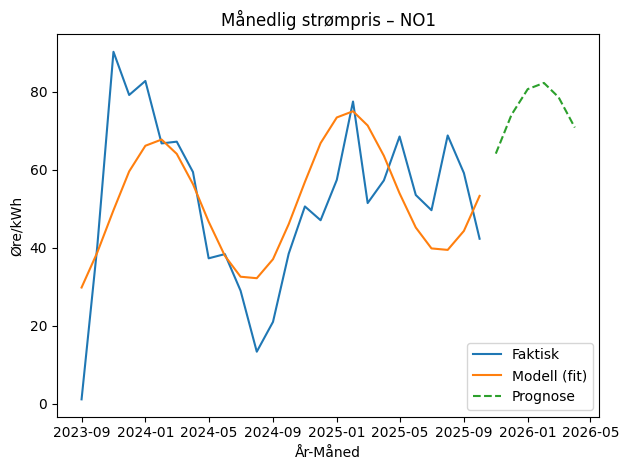

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fitted["år_mnd"], fitted["observed"], label="Faktisk")
plt.plot(fitted["år_mnd"], fitted["fitted"], label="Modell (fit)")
plt.plot(forecast["år_mnd"], forecast["pred_pris_mnd"], label="Prognose", linestyle="--")
plt.title(f"Månedlig strømpris – {area}")
plt.xlabel("År-Måned")
plt.ylabel("Øre/kWh")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
#B) Utvidelse: Døgnsnitt-modell (per område)

# Idé: Aggregér til dagsnivå per område.
# Funksjoner: tidstrend t, måned (sin/cos), ukedag (dummies).
# Modell: LinearRegression.
# Output: predikert døgnsnitt for neste n dager.

#  B) DØGNSNITT-MODELL 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

def make_daily(df_path: str) -> pd.DataFrame:
    """
    Lager daglig snitt per område: kolonner ['dato','område','pris_dag'].
    """
    df = pd.read_csv(df_path, encoding="utf-8")
    dt = pd.to_datetime(df["dato"] + " " + df["time"], format="%Y-%m-%d %H:%M", errors="coerce")
    df["dato"] = dt.dt.date
    daily = (df.groupby(["område","dato"], as_index=False)["pris (øre/kWh)"]
               .mean()
               .rename(columns={"pris (øre/kWh)":"pris_dag"}))
    return daily

def fit_and_forecast_daily(daily_all: pd.DataFrame, area: str, n_days_ahead=14):
    """
    Lineær modell på daglige snitt for valgt område.
    Features: tidsindeks t, måned (sin/cos) + ukedag (one-hot).
    """
    d = (daily_all[daily_all["område"]==area]
         .sort_values("dato")
         .reset_index(drop=True))
    if d.empty:
        raise ValueError(f"Ingen daglige data for {area}")

    d["dato"] = pd.to_datetime(d["dato"])
    # fyll hull
    full_idx = pd.date_range(d["dato"].min(), d["dato"].max(), freq="D")
    d = d.set_index("dato").reindex(full_idx).rename_axis("dato").reset_index()
    d["pris_dag"] = d["pris_dag"].interpolate(limit_direction="both")

    d["t"] = np.arange(len(d))
    d["month"] = d["dato"].dt.month
    d["dow"] = d["dato"].dt.dayofweek
    d["m_sin"] = np.sin(2*np.pi*d["month"]/12.0)
    d["m_cos"] = np.cos(2*np.pi*d["month"]/12.0)

    X = d[["t","m_sin","m_cos","dow"]]
    y = d["pris_dag"].values

    # one-hot for dow
    pre = ColumnTransformer([("dow", OneHotEncoder(drop="first", dtype=int), ["dow"])],
                            remainder="passthrough")
    pipe = Pipeline([("pre", pre), ("lr", LinearRegression())])
    pipe.fit(X, y)

    # Fremtidige dager
    last_date = d["dato"].iloc[-1]
    future_idx = pd.date_range(last_date + pd.Timedelta(days=1), periods=n_days_ahead, freq="D")
    f = pd.DataFrame({"dato": future_idx})
    f["t"] = d["t"].iloc[-1] + 1 + np.arange(n_days_ahead)
    f["month"] = f["dato"].dt.month
    f["dow"] = f["dato"].dt.dayofweek
    f["m_sin"] = np.sin(2*np.pi*f["month"]/12.0)
    f["m_cos"] = np.cos(2*np.pi*f["month"]/12.0)

    yhat = pipe.predict(f[["t","m_sin","m_cos","dow"]])

    forecast = pd.DataFrame({
        "dato": f["dato"].dt.date,
        "område": area,
        "pred_pris_dag": np.round(yhat, 2)
    })
    return pipe, forecast

#  EKSEMPEL 
daily_all = make_daily("strompriser_clean_uten_uteliggere.csv")
pipe, f_dag = fit_and_forecast_daily(daily_all, "NO1", n_days_ahead=14)
print(f_dag.head(10))

         dato område  pred_pris_dag
0  2025-10-08    NO1          62.09
1  2025-10-09    NO1          61.95
2  2025-10-10    NO1          58.96
3  2025-10-11    NO1          49.77
4  2025-10-12    NO1          45.80
5  2025-10-13    NO1          60.53
6  2025-10-14    NO1          62.02
7  2025-10-15    NO1          62.25
8  2025-10-16    NO1          62.12
9  2025-10-17    NO1          59.12


[1] Områdevalg → postnummer=0768 → område=NO1
[2] Leser CSV: Pris (ørekWh) per time for prisområder NO1, NO2, NO3, NO4, NO5 (1).csv
    Antall rader totalt: 92,150
[3] Forbruksmønster bygd (24t, summerer til 1.0)
[4] Beregner daglige snitt og totalsammendrag...
    Ferdig.

— Svar på spørsmål —
* Faktisk pris når du bruker mest (06–09 & 16–22): 64.61 øre/kWh
* Norgespris = 40.00 øre/kWh
  - Peak vs Norgespris  : +24.61 øre → dyrere enn Norgespris
  - Vektet 24t vs Norgespris: +22.35 øre → dyrere enn Norgespris
  - Flatt 24t vs Norgespris : +16.47 øre → dyrere enn Norgespris


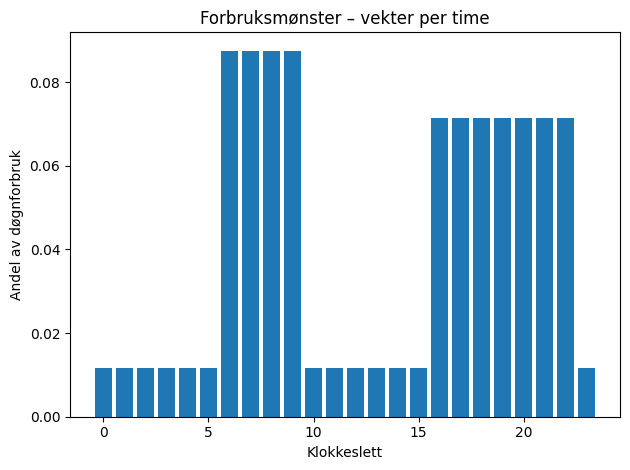

In [ ]:
# Del 5: Realistisk brukerperspektiv – vektet pris mot Norgespris

# Leser opplastede fil og bruker postnummer for områdevalg.
# ----------------------------------------------

from pathlib import Path
import pandas as pd
import numpy as np


NORGESPRIS_ORE = 40.0          # sammenligningspris (øre/kWh)
DEFAULT_AREA = "NO1"
USE_PLOTTING = True            

# Forbruksmønster
MORNING_START, MORNING_END = 6, 9     # 06–09
EVENING_START, EVENING_END = 16, 22   # 16–22
MORNING_SHARE = 0.35                  # 35 % av døgnet
EVENING_SHARE = 0.50                  # 50 % av døgnet

# Postnummer → område
ZIP_RANGES_TO_AREA = [
    (1, 1999, "NO1"),
    (2000, 3999, "NO2"),
    (4000, 5999, "NO2"),
    (6000, 7999, "NO3"),
    (8000, 8999, "NO4"),
    (9000, 9999, "NO4"),
]

# Opplastede fil
FILE_PATH = Path("Pris (ørekWh) per time for prisområder NO1, NO2, NO3, NO4, NO5 (1).csv")


# STEP 1: Hjelpere

def map_zip_to_area(zipcode):
    """Accepts '0150', 150, or None; returns area code."""
    if zipcode is None:
        return DEFAULT_AREA
    # normalizes to digits only
    s = str(zipcode).strip()
    s = "".join(ch for ch in s if ch.isdigit())
    if not s:
        return DEFAULT_AREA
    z = int(s)
    for start, end, area in ZIP_RANGES_TO_AREA:
        if start <= z <= end:
            return area
    return DEFAULT_AREA


def build_hourly_weights():
    """Bygg 24-timers vektvektor etter gitt morgen/kveldsmønster. Summerer til 1.0."""
    weights = np.zeros(24, dtype=float)
    morning_hours = list(range(MORNING_START, MORNING_END + 1))
    evening_hours = list(range(EVENING_START, EVENING_END + 1))
    for h in morning_hours:
        weights[h] += MORNING_SHARE / len(morning_hours)
    for h in evening_hours:
        weights[h] += EVENING_SHARE / len(evening_hours)
    remainder = 1.0 - (MORNING_SHARE + EVENING_SHARE)
    other_hours = [h for h in range(24) if h not in morning_hours + evening_hours]
    for h in other_hours:
        weights[h] += remainder / len(other_hours)
    return weights / weights.sum()

def load_csv_long(path: Path) -> pd.DataFrame:
    """Leser opplastet CSV og returnerer DataFrame med kolonner: ['timestamp','area','price_ore_per_kwh']"""
    if not path.exists():
        raise FileNotFoundError(f"Finner ikke fil: {path}")
    df = pd.read_csv(path, sep=",", engine="python")
    df.columns = [c.strip() for c in df.columns]
    # Map norske kolonnenavn til standard kolonner
    rename_map = {}
    if "Date, time" in df.columns: rename_map["Date, time"] = "timestamp"
    if "Pris" in df.columns: rename_map["Pris"] = "price_ore_per_kwh"
    if "Omrade" in df.columns: rename_map["Omrade"] = "area"
    df = df.rename(columns=rename_map)

    # Standardiserer tid

    df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True, errors="coerce")
    df["area"] = df["area"].str.upper().str.strip()
    if df["price_ore_per_kwh"].dtype == object:
        df["price_ore_per_kwh"] = (
            df["price_ore_per_kwh"].astype(str).str.replace(",", ".", regex=False)
        )
    df["price_ore_per_kwh"] = pd.to_numeric(df["price_ore_per_kwh"], errors="coerce")
    df = df.dropna(subset=["timestamp", "area", "price_ore_per_kwh"])
    return df

def compute_metrics(df_prices: pd.DataFrame, area: str, norgespris_ore: float, weights_24h: np.ndarray):
    """Beregner daglige snitt og totalsammendrag for gitt område og vektmønster."""

    df = df_prices.copy()
    df = df[df["area"] == area].copy()
    if df.empty:
        raise ValueError(f"Ingen rader for område {area} i datafilen.")
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=False)
    df["hour"] = df["timestamp"].dt.hour
    df["date"] = df["timestamp"].dt.date

    # Peak-vindu
    is_morning = df["hour"].between(MORNING_START, MORNING_END, inclusive="both")
    is_evening = df["hour"].between(EVENING_START, EVENING_END, inclusive="both")
    is_peak = is_morning | is_evening

    daily_peak_avg = (
        df[is_peak]
        .groupby("date")["price_ore_per_kwh"]
        .mean()
        .rename("peak_only_avg_ore")
    )

    # Vektet 24t
    w = pd.Series(weights_24h, index=range(24))
    df["hour_weight"] = df["hour"].map(w)
    daily_usage_weighted = (
        (df["price_ore_per_kwh"] * df["hour_weight"])
        .groupby(df["date"])
        .sum()
        .rename("usage_weighted_24h_ore")
    )

    # Flatt 24t
    daily_flat_avg = (
        df.groupby("date")["price_ore_per_kwh"]
        .mean()
        .rename("flat_24h_avg_ore")
    )

    daily = pd.concat([daily_peak_avg, daily_usage_weighted, daily_flat_avg], axis=1).reset_index()

    # Totalsammendrag
    overall_peak_only = float(daily["peak_only_avg_ore"].mean())
    overall_usage_weighted = float(daily["usage_weighted_24h_ore"].mean())
    overall_flat_24h = float(daily["flat_24h_avg_ore"].mean())

    def verdict(x, fixed):
        diff = x - fixed
        if diff > 0: return diff, "dyrere enn Norgespris"
        if diff < 0: return diff, "billigere enn Norgespris"
        return diff, "lik Norgespris"

    diff_peak, v_peak = verdict(overall_peak_only, norgespris_ore)
    diff_weighted, v_weighted = verdict(overall_usage_weighted, norgespris_ore)
    diff_flat, v_flat = verdict(overall_flat_24h, norgespris_ore)

    metrics = {
        "area": area,
        "n_days": int(daily.shape[0]),
        "overall_peak_only_avg_ore": overall_peak_only,
        "overall_usage_weighted_avg_ore": overall_usage_weighted,
        "overall_flat_24h_avg_ore": overall_flat_24h,
        "norgespris_ore": float(norgespris_ore),
        "peak_vs_norgespris_diff_ore": float(diff_peak),
        "usage_weighted_vs_norgespris_diff_ore": float(diff_weighted),
        "flat_vs_norgespris_diff_ore": float(diff_flat),
        "verdict_peak": v_peak,
        "verdict_weighted": v_weighted,
        "verdict_flat": v_flat,
    }
    return metrics, df, daily


# STEP 4: Sjekker med postnummer

def main(user_zipcode=None):
    # 4.1 Område fra postnummer
    area = map_zip_to_area(user_zipcode)
    print(f"[1] Områdevalg → postnummer={user_zipcode} → område={area}")

    # 4.2 Leser data fra opplastet fil
    print(f"[2] Leser CSV: {FILE_PATH.name}")
    df_long = load_csv_long(FILE_PATH)
    print(f"    Antall rader totalt: {len(df_long):,}")

    # 4.3 Forbruksmønster
    weights = build_hourly_weights()
    print("[3] Forbruksmønster bygd (24t, summerer til 1.0)")

    # 4.4 Beregner metrikker
    print("[4] Beregner daglige snitt og totalsammendrag...")
    metrics, df_used, daily_table = compute_metrics(df_long, area=area, norgespris_ore=NORGESPRIS_ORE, weights_24h=weights)
    print("    Ferdig.")

    # 4.5 Svarer på spørsmål
    print("\n— Svar på spørsmål —")
    print(f"* Faktisk pris når du bruker mest (06–09 & 16–22): {metrics['overall_peak_only_avg_ore']:.2f} øre/kWh")
    print(f"* Norgespris = {metrics['norgespris_ore']:.2f} øre/kWh")
    print(f"  - Peak vs Norgespris  : {metrics['peak_vs_norgespris_diff_ore']:+.2f} øre → {metrics['verdict_peak']}")
    print(f"  - Vektet 24t vs Norgespris: {metrics['usage_weighted_vs_norgespris_diff_ore']:+.2f} øre → {metrics['verdict_weighted']}")
    print(f"  - Flatt 24t vs Norgespris : {metrics['flat_vs_norgespris_diff_ore']:+.2f} øre → {metrics['verdict_flat']}")

    # 4.6 (Valgfritt) Grafer
    if USE_PLOTTING:
        import matplotlib.pyplot as plt

        # Graf: vektvektor
        plt.figure()
        plt.bar(range(24), weights)
        plt.title("Forbruksmønster – vekter per time")
        plt.xlabel("Klokkeslett")
        plt.ylabel("Andel av døgnforbruk")
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # Skriv inn postnummer. Hvis None → bruker DEFAULT_AREA.
    user_zip = "0768"
    main(user_zipcode=user_zip)



Kort sammendrag:
- Område: NO1  |  Dager: 768  |  Datoperiode: alle datoer
- Resultater (øre/kWh):
  • Peak-vindu (06–09 & 16–22): 64.61
  • Vektet 24t-snitt           : 62.35
  • Flatt 24t-snitt            : 56.47
- Norgespris: 40.00 øre/kWh
- Vurdering:
  • Peak vs Norgespris  : +24.61 øre → dyrere enn Norgespris
  • Vektet vs Norgespris: +22.35 øre → dyrere enn Norgespris
  • Flatt vs Norgespris : +16.47 øre → dyrere enn Norgespris



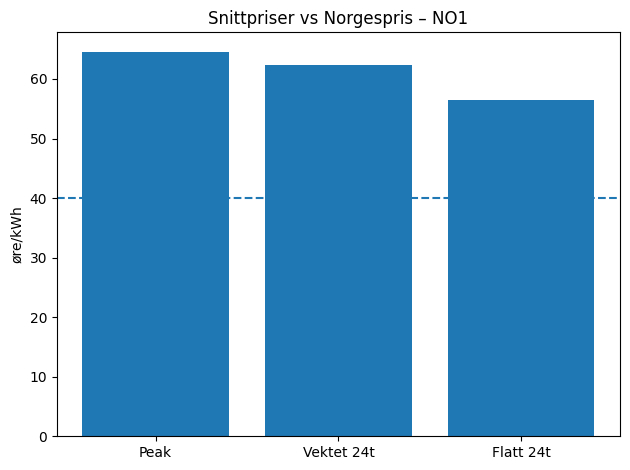

In [ ]:
# Short human summary + result illustration
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#  CONFIGURATION
FILE_PATH = Path("Pris (ørekWh) per time for prisområder NO1, NO2, NO3, NO4, NO5 (1).csv")
USER_ZIPCODE = "0150"          
DEFAULT_AREA = "NO1"
NORGESPRIS_ORE = 40.0
DATE_FILTER = None             

# Forbruksmønster (Del 5)
MORNING_START, MORNING_END = 6, 9
EVENING_START, EVENING_END = 16, 22
MORNING_SHARE = 0.35
EVENING_SHARE = 0.50

#  Postnummer → område
ZIP_RANGES_TO_AREA = [
    (1, 1999, "NO1"), (2000, 2999, "NO1"),
    (3000, 3999, "NO2"), (4000, 4999, "NO2"),
    (5000, 5999, "NO5"),
    (6000, 6999, "NO3"), (7000, 7999, "NO3"),
    (8000, 8999, "NO4"), (9000, 9999, "NO4"),
]

# Helpers
def map_zip_to_area(zipcode):
    if zipcode is None: return DEFAULT_AREA
    s = "".join(ch for ch in str(zipcode) if ch.isdigit())
    if not s: return DEFAULT_AREA
    z = int(s)
    for a, b, area in ZIP_RANGES_TO_AREA:
        if a <= z <= b:
            return area
    return DEFAULT_AREA

def load_csv_long(path: Path) -> pd.DataFrame:
    
    df = pd.read_csv(path, sep=",", engine="python")
    df = df.rename(columns={"Date, time": "timestamp", "Pris": "price_ore_per_kwh", "Omrade": "area"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True, errors="coerce")
    if df["price_ore_per_kwh"].dtype == object:
        df["price_ore_per_kwh"] = df["price_ore_per_kwh"].astype(str).str.replace(",", ".", regex=False)
    df["price_ore_per_kwh"] = pd.to_numeric(df["price_ore_per_kwh"], errors="coerce")
    df["area"] = df["area"].astype(str).str.upper().str.strip()
    return df.dropna(subset=["timestamp", "price_ore_per_kwh", "area"])

def apply_date_filter(df: pd.DataFrame, date_range):
    if not date_range: return df, None
    start, end = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
    m = (df["timestamp"] >= start) & (df["timestamp"] <= end)
    return df.loc[m].copy(), (start, end)

def build_hourly_weights():
    w = np.zeros(24, dtype=float)
    morning = list(range(MORNING_START, MORNING_END + 1))
    evening = list(range(EVENING_START, EVENING_END + 1))
    for h in morning: w[h] += MORNING_SHARE / len(morning)
    for h in evening: w[h] += EVENING_SHARE / len(evening)
    rest = 1.0 - (MORNING_SHARE + EVENING_SHARE)
    other = [h for h in range(24) if h not in morning + evening]
    for h in other: w[h] += rest / len(other)
    return w / w.sum()

def compute_metrics(df: pd.DataFrame, area: str, norgespris: float, weights_24h: np.ndarray):
    d = df[df["area"] == area].copy()
    if d.empty: raise ValueError(f"Ingen rader for område {area}.")
    d["hour"] = d["timestamp"].dt.hour
    d["date"] = d["timestamp"].dt.date

    is_morn = d["hour"].between(MORNING_START, MORNING_END, inclusive="both")
    is_even = d["hour"].between(EVENING_START, EVENING_END, inclusive="both")
    is_peak = is_morn | is_even

    daily_peak = d[is_peak].groupby("date")["price_ore_per_kwh"].mean()
    w = pd.Series(weights_24h, index=range(24))
    d["hour_weight"] = d["hour"].map(w)
    daily_weighted = (d["price_ore_per_kwh"] * d["hour_weight"]).groupby(d["date"]).sum()
    daily_flat = d.groupby("date")["price_ore_per_kwh"].mean()

    peak_avg = float(daily_peak.mean())
    weighted_avg = float(daily_weighted.mean())
    flat_avg = float(daily_flat.mean())

    def verdict(x, ref):
        diff = x - ref
        return diff, ("dyrere enn Norgespris" if diff > 0 else ("billigere enn Norgespris" if diff < 0 else "lik Norgespris"))

    dp, vp = verdict(peak_avg, norgespris)
    dw, vw = verdict(weighted_avg, norgespris)
    df_, vf = verdict(flat_avg, norgespris)

    return {
        "area": area, "days": int(daily_flat.shape[0]),
        "peak_avg": peak_avg, "weighted_avg": weighted_avg, "flat_avg": flat_avg,
        "norgespris": norgespris,
        "peak_diff": dp, "weighted_diff": dw, "flat_diff": df_,
        "v_peak": vp, "v_weighted": vw, "v_flat": vf
    }

def print_human_summary(metrics, date_range_used):
    dr = "alle datoer" if not date_range_used else f"{date_range_used[0].date()} til {date_range_used[1].date()}"
    print(
        f"\nKort sammendrag:"
        f"\n- Område: {metrics['area']}  |  Dager: {metrics['days']}  |  Datoperiode: {dr}"
        f"\n- Resultater (øre/kWh):"
        f"\n  • Peak-vindu (06–09 & 16–22): {metrics['peak_avg']:.2f}"
        f"\n  • Vektet 24t-snitt           : {metrics['weighted_avg']:.2f}"
        f"\n  • Flatt 24t-snitt            : {metrics['flat_avg']:.2f}"
        f"\n- Norgespris: {metrics['norgespris']:.2f} øre/kWh"
        f"\n- Vurdering:"
        f"\n  • Peak vs Norgespris  : {metrics['peak_diff']:+.2f} øre → {metrics['v_peak']}"
        f"\n  • Vektet vs Norgespris: {metrics['weighted_diff']:+.2f} øre → {metrics['v_weighted']}"
        f"\n  • Flatt vs Norgespris : {metrics['flat_diff']:+.2f} øre → {metrics['v_flat']}\n"
    )

def plot_result_illustration(metrics):
    # Simple bar chart of the three averages + horizontal line for Norgespris
    names = ["Peak", "Vektet 24t", "Flatt 24t"]
    vals = [metrics["peak_avg"], metrics["weighted_avg"], metrics["flat_avg"]]
    plt.figure()
    plt.bar(names, vals)
    plt.axhline(metrics["norgespris"], linestyle="--")
    plt.title(f"Snittpriser vs Norgespris – {metrics['area']}")
    plt.ylabel("øre/kWh")
    plt.tight_layout()
    plt.show()

# Pipeline
area = map_zip_to_area(USER_ZIPCODE)
df_all = load_csv_long(FILE_PATH)
df_filt, used_range = apply_date_filter(df_all, DATE_FILTER)
weights = build_hourly_weights()
m = compute_metrics(df_filt, area=area, norgespris=NORGESPRIS_ORE, weights_24h=weights)

print_human_summary(m, used_range)
plot_result_illustration(m)


Kort sammendrag (2025-10-15 22:17):
- Datakilde: CSV (eksisterende df_all gjenbrukt) — Pris (ørekWh) per time for prisområder NO1, NO2, NO3, NO4, NO5 (1).csv
- Områdevalg: postnummer=0150 → område=NO1
- Datoperiode brukt: alle datoer (antall dager: 768)
- Metode (Del 5: realistisk forbruksmønster):
  • Morgen-vindu 06–09 med 35% av døgnet
  • Kveld-vindu  16–22 med 50% av døgnet
  • Resterende forbruk fordelt jevnt på øvrige timer
- Beregninger:
  • Peak-vindu-snitt (kun 06–09 & 16–22)
  • 24t vektet snitt (etter mønsteret over)
  • 24t flatt snitt (referanse)
- Resultater (øre/kWh):
  • Peak-vindu: 64.61
  • Vektet 24t: 62.35
  • Flatt 24t : 56.47
- Sammenligning med Norgespris = 40.00 øre/kWh:
  • Peak  vs Norgespris: +24.61 øre → dyrere enn Norgespris
  • Vektet vs Norgespris: +22.35 øre → dyrere enn Norgespris
  • Flatt  vs Norgespris: +16.47 øre → dyrere enn Norgespris


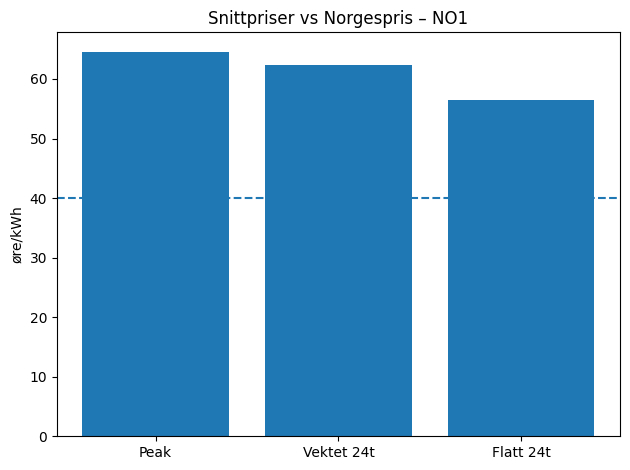


Lagret filer:
 - Sammendrag: notebook_run_summary.txt
 - Figur     : notebook_result.png


In [ ]:
# FINAL CELL: Human summary + result illustration (auto-detects prior work)
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


# Defaults (used only if missing in notebook)

DEFAULTS = {
    "FILE_PATH": Path("/mnt/data/Pris (ørekWh) per time for prisområder NO1, NO2, NO3, NO4, NO5 (1).csv"),
    "USER_ZIPCODE": None,     # e.g. "0150" or 5003 (string or int)
    "DEFAULT_AREA": "NO1",
    "NORGESPRIS_ORE": 40.0,
    "DATE_FILTER": None,      # e.g. ("2024-01-01","2024-01-31") or None
    "MORNING_START": 6, "MORNING_END": 9,
    "EVENING_START": 16, "EVENING_END": 22,
    "MORNING_SHARE": 0.35, "EVENING_SHARE": 0.50,
    "ZIP_RANGES_TO_AREA": [
        (1,1999,"NO1"), (2000,2999,"NO1"), (3000,3999,"NO2"), (4000,4999,"NO2"),
        (5000,5999,"NO5"), (6000,6999,"NO3"), (7000,7999,"NO3"), (8000,8999,"NO4"), (9000,9999,"NO4"),
    ],
}

g = globals()
for k,v in DEFAULTS.items():
    if k not in g:
        g[k] = v


# Small helpers

def _map_zip_to_area(zipcode, default_area, zip_map):
    if zipcode is None: return default_area
    s = "".join(ch for ch in str(zipcode) if ch.isdigit())
    if not s: return default_area
    z = int(s)
    for a,b,area in zip_map:
        if a <= z <= b:
            return area
    return default_area

def _load_csv_long(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, sep=",", engine="python")
    
    df = df.rename(columns={"Date, time": "timestamp", "Pris": "price_ore_per_kwh", "Omrade": "area"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True, errors="coerce")
    if df["price_ore_per_kwh"].dtype == object:
        df["price_ore_per_kwh"] = df["price_ore_per_kwh"].astype(str).str.replace(",", ".", regex=False)
    df["price_ore_per_kwh"] = pd.to_numeric(df["price_ore_per_kwh"], errors="coerce")
    df["area"] = df["area"].astype(str).str.upper().str.strip()
    return df.dropna(subset=["timestamp","price_ore_per_kwh","area"])

def _apply_date_filter(df: pd.DataFrame, date_range):
    if not date_range:
        return df, None
    start, end = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
    m = (df["timestamp"] >= start) & (df["timestamp"] <= end)
    return df.loc[m].copy(), (start, end)

def _build_hourly_weights(MORNING_START, MORNING_END, EVENING_START, EVENING_END, MORNING_SHARE, EVENING_SHARE):
    w = np.zeros(24, dtype=float)
    morning = list(range(MORNING_START, MORNING_END + 1))
    evening = list(range(EVENING_START, EVENING_END + 1))
    for h in morning: w[h] += MORNING_SHARE / len(morning)
    for h in evening: w[h] += EVENING_SHARE / len(evening)
    rest = 1.0 - (MORNING_SHARE + EVENING_SHARE)
    other = [h for h in range(24) if h not in morning + evening]
    for h in other: w[h] += rest / len(other)
    return w / w.sum()

def _compute_metrics(df: pd.DataFrame, area: str, norgespris: float,
                     MORNING_START=6, MORNING_END=9, EVENING_START=16, EVENING_END=22,
                     MORNING_SHARE=0.35, EVENING_SHARE=0.50):
    d = df[df["area"] == area].copy()
    if d.empty: raise ValueError(f"Ingen rader for område {area}.")
    d["hour"] = d["timestamp"].dt.hour
    d["date"] = d["timestamp"].dt.date

    is_morn = d["hour"].between(MORNING_START, MORNING_END, inclusive="both")
    is_even = d["hour"].between(EVENING_START, EVENING_END, inclusive="both")
    is_peak = is_morn | is_even

    daily_peak = d[is_peak].groupby("date")["price_ore_per_kwh"].mean()
    w = _build_hourly_weights(MORNING_START, MORNING_END, EVENING_START, EVENING_END, MORNING_SHARE, EVENING_SHARE)
    ws = pd.Series(w, index=range(24))
    d["hour_weight"] = d["hour"].map(ws)
    daily_weighted = (d["price_ore_per_kwh"] * d["hour_weight"]).groupby(d["date"]).sum()
    daily_flat = d.groupby("date")["price_ore_per_kwh"].mean()

    peak_avg = float(daily_peak.mean())
    weighted_avg = float(daily_weighted.mean())
    flat_avg = float(daily_flat.mean())

    def _verdict(x, ref):
        diff = x - ref
        return diff, ("dyrere enn Norgespris" if diff > 0 else ("billigere enn Norgespris" if diff < 0 else "lik Norgespris"))

    dp, vp = _verdict(peak_avg, norgespris)
    dw, vw = _verdict(weighted_avg, norgespris)
    df_, vf = _verdict(flat_avg, norgespris)

    daily_table = pd.DataFrame({
        "date": daily_flat.index,
        "peak_only_avg_ore": daily_peak.reindex(daily_flat.index).values,
        "usage_weighted_24h_ore": daily_weighted.reindex(daily_flat.index).values,
        "flat_24h_avg_ore": daily_flat.values,
    })

    return {
        "area": area, "days": int(daily_flat.shape[0]),
        "peak_avg": peak_avg, "weighted_avg": weighted_avg, "flat_avg": flat_avg,
        "norgespris": norgespris,
        "peak_diff": dp, "weighted_diff": dw, "flat_diff": df_,
        "v_peak": vp, "v_weighted": vw, "v_flat": vf,
        "pattern": {
            "morning": (MORNING_START, MORNING_END, MORNING_SHARE),
            "evening": (EVENING_START, EVENING_END, EVENING_SHARE),
        }
    }, daily_table


# 1) Gathering context from prior notebook state (if available). Reusing variables if they exist; if not, compute from scratch:

FILE_PATH = g.get("FILE_PATH", DEFAULTS["FILE_PATH"])
USER_ZIPCODE = g.get("USER_ZIPCODE", DEFAULTS["USER_ZIPCODE"])
DEFAULT_AREA = g.get("DEFAULT_AREA", DEFAULTS["DEFAULT_AREA"])
NORGESPRIS_ORE = g.get("NORGESPRIS_ORE", DEFAULTS["NORGESPRIS_ORE"])
DATE_FILTER = g.get("DATE_FILTER", DEFAULTS["DATE_FILTER"])
MORNING_START = g.get("MORNING_START", DEFAULTS["MORNING_START"])
MORNING_END = g.get("MORNING_END", DEFAULTS["MORNING_END"])
EVENING_START = g.get("EVENING_START", DEFAULTS["EVENING_START"])
EVENING_END = g.get("EVENING_END", DEFAULTS["EVENING_END"])
MORNING_SHARE = g.get("MORNING_SHARE", DEFAULTS["MORNING_SHARE"])
EVENING_SHARE = g.get("EVENING_SHARE", DEFAULTS["EVENING_SHARE"])
ZIP_RANGES_TO_AREA = g.get("ZIP_RANGES_TO_AREA", DEFAULTS["ZIP_RANGES_TO_AREA"])

# Area from zip 
area = _map_zip_to_area(USER_ZIPCODE, DEFAULT_AREA, ZIP_RANGES_TO_AREA)

# Use existing dataframes
if "df_all" in g and isinstance(g["df_all"], pd.DataFrame):
    df_all = g["df_all"]
else:
    df_all = _load_csv_long(FILE_PATH)

if "df_filtered" in g and isinstance(g["df_filtered"], pd.DataFrame):
    df_filt = g["df_filtered"]
    used_range = g.get("used_range", None)
else:
    df_filt, used_range = _apply_date_filter(df_all, DATE_FILTER)

# Reusing existing 'daily_table' & 'metrics'
if "daily_table" in g and "metrics" in g and isinstance(g["daily_table"], pd.DataFrame) and isinstance(g["metrics"], dict):
    metrics = g["metrics"]
    daily_table = g["daily_table"]
else:
    metrics, daily_table = _compute_metrics(
        df_filt, area=area, norgespris=NORGESPRIS_ORE,
        MORNING_START=MORNING_START, MORNING_END=MORNING_END,
        EVENING_START=EVENING_START, EVENING_END=EVENING_END,
        MORNING_SHARE=MORNING_SHARE, EVENING_SHARE=EVENING_SHARE
    )


# 2) Human summary of what was done

period_text = ("alle datoer" if not used_range else f"{used_range[0].date()} til {used_range[1].date()}")
ms, me, mshare = metrics["pattern"]["morning"]
es, ee, eshare = metrics["pattern"]["evening"]

summary_text = f"""
Kort sammendrag ({datetime.now().strftime('%Y-%m-%d %H:%M')}):
- Datakilde: CSV {'(eksisterende df_all gjenbrukt)' if 'df_all' in g else ''} — {FILE_PATH.name}
- Områdevalg: postnummer={USER_ZIPCODE} → område={metrics['area']}
- Datoperiode brukt: {period_text} (antall dager: {metrics['days']})
- Metode (Del 5: realistisk forbruksmønster):
  • Morgen-vindu {ms:02d}–{me:02d} med {int(mshare*100)}% av døgnet
  • Kveld-vindu  {es:02d}–{ee:02d} med {int(eshare*100)}% av døgnet
  • Resterende forbruk fordelt jevnt på øvrige timer
- Beregninger:
  • Peak-vindu-snitt (kun 06–09 & 16–22)
  • 24t vektet snitt (etter mønsteret over)
  • 24t flatt snitt (referanse)
- Resultater (øre/kWh):
  • Peak-vindu: {metrics['peak_avg']:.2f}
  • Vektet 24t: {metrics['weighted_avg']:.2f}
  • Flatt 24t : {metrics['flat_avg']:.2f}
- Sammenligning med Norgespris = {metrics['norgespris']:.2f} øre/kWh:
  • Peak  vs Norgespris: {metrics['peak_diff']:+.2f} øre → {metrics['v_peak']}
  • Vektet vs Norgespris: {metrics['weighted_diff']:+.2f} øre → {metrics['v_weighted']}
  • Flatt  vs Norgespris: {metrics['flat_diff']:+.2f} øre → {metrics['v_flat']}
""".strip()

print(summary_text)

# Save to file
out_txt = Path("notebook_run_summary.txt")
out_txt.write_text(summary_text, encoding="utf-8")


# 3) Result illustration

vals = [metrics["peak_avg"], metrics["weighted_avg"], metrics["flat_avg"]]
labels = ["Peak", "Vektet 24t", "Flatt 24t"]

plt.figure()
plt.bar(labels, vals)
plt.axhline(metrics["norgespris"], linestyle="--")
plt.title(f"Snittpriser vs Norgespris – {metrics['area']}")
plt.ylabel("øre/kWh")
plt.tight_layout()
# Save and also display
out_png = Path("notebook_result.png")
plt.savefig(out_png, dpi=150)
plt.show()

print("\nLagret filer:")
print(" - Sammendrag:", out_txt.as_posix())
print(" - Figur     :", out_png.as_posix())
